In [1]:
import numpy as np
import pandas as pd
TimeeventsDir = './python/decoherent.dat'
import matplotlib.pyplot as plt
# open timeevents
events = []
with open(TimeeventsDir, 'r') as f:
    lines = f.readlines()
    for event in lines:
        # 
        if(event == '\n'):
            continue
        event = event.replace('\n','').split(' ')
        detector = event[0]
        time = int(event[1])
        events.append([detector, time])
# create dataframe
df = pd.DataFrame(events, columns=['Detector', 'Time'])
df

,Detector,Time
0,00001,408792
1,00001,584744
2,00010,649340
3,00001,1153666
4,00001,1224552
...,...,...
98189,00001,100269046
98190,00010,100605206
98191,00010,100651878
98192,00001,100698462


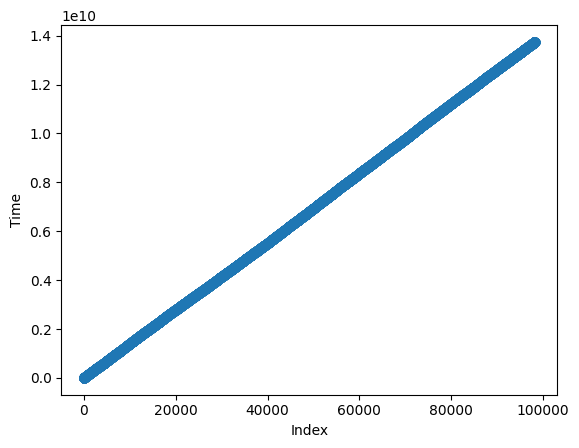

,Detector,Time
0,00001,408792
1,00001,584744
2,00010,649340
3,00001,1153666
4,00001,1224552
...,...,...
98189,00001,13745559444
98190,00010,13745895604
98191,00010,13745942276
98192,00001,13745988860


: 

In [2]:
# what we want to do, is update the graph
# get the ith row of the dataframe


def optimize_time_series(df):
    # Convert Time column to numpy array for faster operations
    times = df['Time'].values
    
    # Calculate differences between consecutive times
    time_diffs = np.diff(times)
    
    # Find where resets occur (negative differences larger than a threshold)
    reset_mask = time_diffs < -900e5  # Assuming reset happens around 990e6
    # Create an array of corrections
    corrections = np.zeros_like(times)
    corrections[1:][reset_mask] = times[:-1][reset_mask]
    
    # Apply corrections cumulatively
    final_corrections = np.cumsum(corrections)
    
    # Apply corrections to the original times
    df['Time'] = times + final_corrections
    
    return df

# Apply the function to your DataFrame
df = optimize_time_series(df)
plt.plot(df.index,df['Time'],  'o')
plt.xlabel('Index')
plt.ylabel('Time')
plt.show()
df


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your original DataFrame with 'Detector' and 'Time' columns

# Convert Time to numeric (nanoseconds since epoch)
df['Time'] = pd.to_numeric(df['Time'])

# Set the bin size (in nanoseconds)
bin_size = 1  # ns

# Calculate bin edges
bin_edges = np.arange(df['Time'].min(), df['Time'].max() + bin_size, bin_size)

# Create a new DataFrame with time bins as index and detectors as columns
time_bins = pd.cut(df['Time'], bins=bin_edges)
detector_counts = df.groupby([time_bins, 'Detector']).size().unstack(fill_value=0)

# Rename the index to the middle of each time bin and convert to datetime
# detector_counts.index = pd.to_datetime(detector_counts.index.map(lambda x: x.mid), unit='ns')


In [ ]:

# Plot using the new DataFrame
plt.figure(figsize=(12, 6))
for detector in detector_counts.columns:
    plt.plot(detector_counts.index, detector_counts[detector], label=f'Detector {detector}')

plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.title(f'Events per {bin_size/1e6:.2f}-millisecond bin by Detector')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some information about the new DataFrame
print(f"Shape of detector_counts: {detector_counts.shape}")
print(f"Columns (detectors): {detector_counts.columns.tolist()}")
print(f"Time range: {detector_counts.index.min()} to {detector_counts.index.max()}")

# Display the first few rows of the DataFrame
print("\nFirst few rows of the detector_counts DataFrame:")
print(detector_counts.head())

# Optionally, save the DataFrame to a CSV file
detector_counts

In [ ]:
# get the average counts over the time bins, then normalize
average_counts = detector_counts.quantile(0.25, axis=0)
# make average counts equal to the 90th percentile

print(average_counts)
normalized_counts = detector_counts.div(average_counts, axis=1)


Detector
00001    16.0
00010    20.0
Name: 0.25, dtype: float64


(2291,)
(2291,)


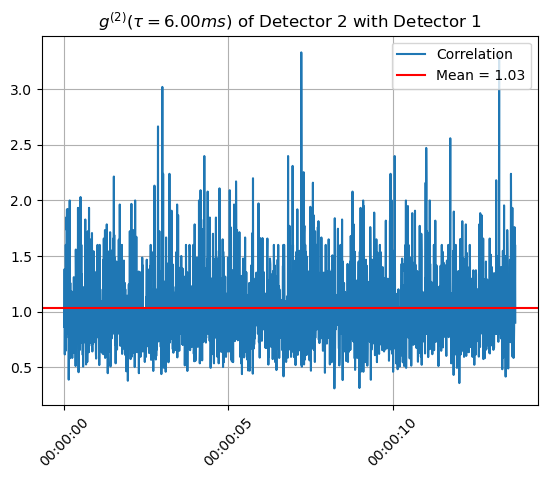

In [ ]:
offset = 1
# offset is in time, measured by binsize*offset
normalized_counts['correlationMain'] = (normalized_counts['00001'][offset:-offset]*normalized_counts['00010'][offset:-offset])/(normalized_counts['00001'][offset:-offset]**2)
print(normalized_counts['correlationMain'].shape)
print(normalized_counts.index.shape)
plt.plot(normalized_counts.index, normalized_counts['correlationMain'], label='Correlation')
test = round(normalized_counts['correlationMain'].mean(),2)
plt.axhline(y=normalized_counts['correlationMain'].mean(), color='r', linestyle='-',label=f'Mean = {test}')
plt.xticks(rotation=45)
plt.title('$g^{(2)}(\\tau='+f'{offset*bin_size/1e6:.2f}ms'+f')$ of Detector 2 with Detector 1') 
plt.legend()
plt.grid()
plt.show()

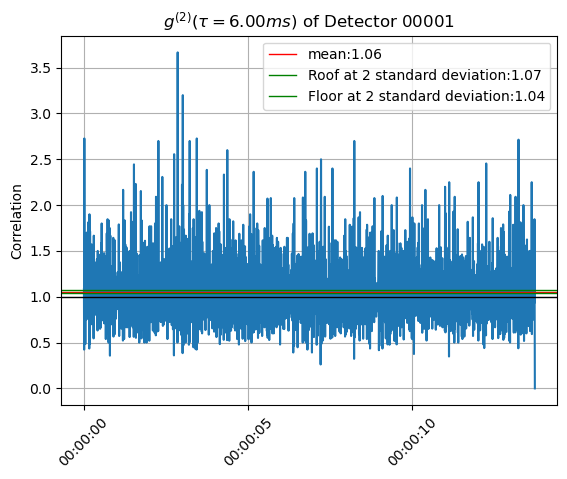

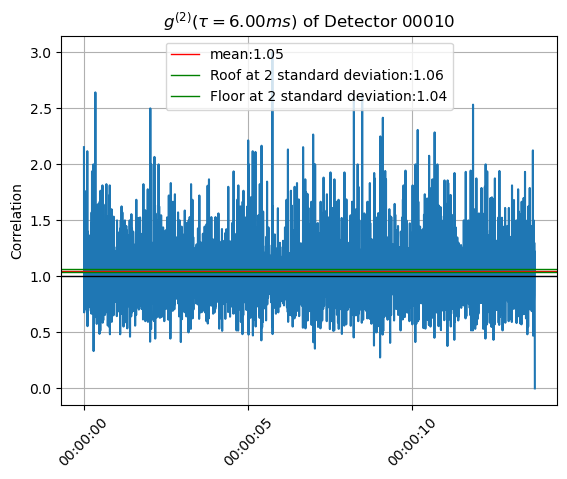

In [ ]:
# normalized_counts['corerlation'] = (normalized_counts['00001']*normalized_counts['00010'])*(normalized_counts['00001']**2)
# we want to check correlation of something with itself, so we'll make it a numpy list, then correlate with the index one over
def correlate(df,detector = '00001'):
    offset = 1
    # that above is 6ms
    I0 = df[detector].to_numpy()[:-offset]
    Itau = df[detector].to_numpy()[offset:]
    # append zero to the very beggining
    result = (I0*Itau)/(I0**2)
    df['correlation'] = np.append(result,0)
    plt.plot(normalized_counts.index, df['correlation'])
    plt.grid()
    plt.ylabel('Correlation')
    plt.axhline(1, color='black', lw=1)

    mean = df['correlation'].mean()
    standardError = df['correlation'].std()/np.sqrt(len(df['correlation']))
    plt.axhline(mean, color='red', lw=1,label  = f'mean:{round(mean,2)}')
    # rotate the labels on x axis, put them in MM:SS format
    plt.axhline(mean+2*standardError, color='green', lw=1,label  = f'Roof at 2 standard deviation:{round(mean+2*standardError,2)}')

    plt.axhline(mean-2*standardError, color='green', lw=1,label  = f'Floor at 2 standard deviation:{round(mean-2*standardError,2)}')
    plt.xticks(rotation=45)
    plt.title('$g^{(2)}(\\tau='+f'{bin_size/1e6:.2f}ms'+f')$ of Detector {detector}') 
    plt.legend()
    plt.show()
    
correlate(normalized_counts,detector='00001')
correlate(normalized_counts,detector='00010')